# Adversarial Autoencoder on MNIST Dataset

<img src="adversarial_autoencoder_model.png" width="800px" style="float:center" >

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


## Utilities

In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "aae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    
    cmap = plt.get_cmap('RdBu', np.max(y_test)-np.min(y_test)+1)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap=cmap, vmin = np.min(y_test)-.5, vmax = np.max(y_test)+.5)
    plt.colorbar(ticks=np.arange(np.min(y_test),np.max(y_test)+1))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "latent_manifold.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

## Load dataset

In [3]:
# load the dataset without labels

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape images
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
layer_1_dim = 3000
layer_2_dim = 3000
batch_size = 100
latent_dim = 2
epochs = 50

kernel_initializer = 'glorot_uniform'
bias_initializer = 'zeros'

#kernel_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)
#bias_initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)

## Build the adversarial autoencoder model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 784)          0                                            
__________________________________________________________________________________________________
DO (Dropout)                    (None, 784)          0           X[0][0]                          
__________________________________________________________________________________________________
H1 (Dense)                      (None, 3000)         2355000     DO[0][0]                         
__________________________________________________________________________________________________
BN_1 (BatchNormalizat

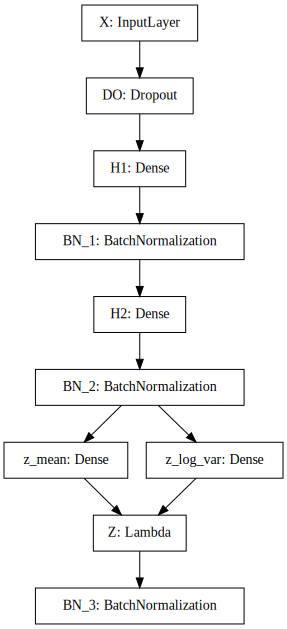

In [4]:
# AAE model = encoder + decoder + discriminator + generator

# TODO: implement: 1) DETERMINISTIC POSTERIOR Q(z|x); 2) UNIVERSAL APPROXIMATOR POSTERIOR

# GAUSSIAN POSTERIOR
# build encoder model 
encoder_input = Input(shape=input_shape, name="X")
x = Dropout(rate=0.2, name='DO')(encoder_input)
x = Dense(layer_1_dim, activation='relu', name="H1", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)
x = BatchNormalization(name='BN_1')(x)
x = Dense(layer_2_dim, activation='relu', name="H2", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)
x = BatchNormalization(name='BN_2')(x)
z_mean = Dense(latent_dim, name='z_mean', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)
z_log_var = Dense(latent_dim, name='z_log_var', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='Z')([z_mean, z_log_var])
z = BatchNormalization(name='BN_3')(z)

# instantiate encoder model
encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='img/aae_encoder_mnist.png', show_shapes=True)
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 2)                 0         
_________________________________________________________________
H1 (Dense)                   (None, 3000)              9000      
_________________________________________________________________
H2 (Dense)                   (None, 3000)              9003000   
_________________________________________________________________
Xp (Dense)                   (None, 784)               2352784   
Total params: 11,364,784
Trainable params: 11,364,784
Non-trainable params: 0
_________________________________________________________________


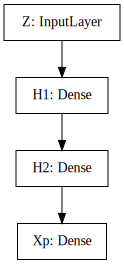

In [5]:
# build decoder model
decoder_input = Input(shape=(latent_dim,), name='Z')
x = Dense(layer_1_dim, activation='relu', name="H1", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(decoder_input)
x = Dense(layer_2_dim, activation='relu', name="H2", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)
x = Dense(original_dim, activation='sigmoid', name="Xp", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)

# instantiate decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()
plot_model(decoder, to_file='img/aae_decoder_mnist.png', show_shapes=True)
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 2)                 0         
_________________________________________________________________
H1 (Dense)                   (None, 3000)              9000      
_________________________________________________________________
H2 (Dense)                   (None, 3000)              9003000   
_________________________________________________________________
Check (Dense)                (None, 1)                 3001      
Total params: 9,015,001
Trainable params: 9,015,001
Non-trainable params: 0
_________________________________________________________________


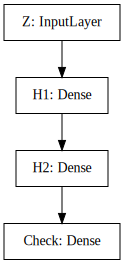

In [6]:
# build discriminator model

discr_input = Input(shape=(latent_dim,), name='Z')
x = Dense(layer_1_dim, activation='relu', name="H1", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(discr_input)
x = Dense(layer_2_dim, activation='relu', name="H2", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)
x = Dense(1, activation='sigmoid', name="Check", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)

# instantiate decoder model
discriminator = Model(discr_input, x, name='discriminator')
discriminator.summary()
plot_model(decoder, to_file='img/aae_discriminator_mnist.png', show_shapes=True)
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 11394012    X[0][0]                          
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          11364784    encoder[1][2]                    
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            9015001     encoder[1][2]                    
Total params: 31,773,797
Trainable params: 31,761,793
Non-trainable params: 12,004
__________________________

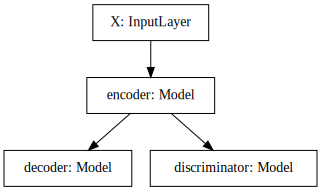

In [7]:
# instantiate AAE model
real_input = encoder_input
compression = encoder(encoder_input)[2]
reconstruction = decoder(compression)
generation = discriminator(compression)
 
aae = Model(encoder_input, [reconstruction, generation], name='autoencoder')
aae.summary()
plot_model(aae, to_file='img/aae_autoencoder_mnist.png', show_shapes=True)
SVG(model_to_dot(aae).create(prog='dot', format='svg'))

## Train the adversarial autoencoder

Let's visualize the results of a model during training using the TensorFlow backend and the TensorBoard callback.

!tensorboard --logdir==training:/tmp/aae --host=127.0.0.1

open [tensorboard](127.0.0.1:6006)

In [ ]:
# let's train the models

optimizer = Adam(0.0001, 0.5) 
#optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9)

discriminator.trainable = False
discriminator.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

aae.compile(optimizer=optimizer, 
            loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001])

for epoch in range(epochs):
    np.random.shuffle(x_train)
    
    for i in range(int(len(x_train) / batch_size)):
        
        batch = x_train[i*batch_size:i*batch_size+batch_size]
        
        # Regularization phase
        fake_pred = encoder.predict(batch)[2]
        real_pred = np.random.normal(size=(batch_size,latent_dim)) # prior distribution
        discriminator_batch_x = np.concatenate([fake_pred, real_pred])
        discriminator_batch_y = np.concatenate([np.zeros(batch_size), np.ones(batch_size)])
        discriminator_history = discriminator.fit(x=discriminator_batch_x, 
                                                  y=discriminator_batch_y, 
                                                  epochs=1, 
                                                  batch_size=batch_size, 
                                                  validation_split=0.0, 
                                                  verbose=0)#,
                                                  #callbacks=[TensorBoard(log_dir='/tmp/aae_2')])
        
        # Reconstruction phase
        #aae.train_on_batch(batch, [batch,np.ones(batch_size,1)])
        aae_history = aae.fit(x=batch, 
                              y=[batch, np.ones(batch_size)], 
                              epochs=1, 
                              batch_size=batch_size, 
                              validation_split=0.0, 
                              verbose=0)#,
                              #callbacks=[TensorBoard(log_dir='/tmp/aae_1')])
    
    #if (epoch+1)%10 == 0:
    print("Epoch {0:d}/{1:d}, reconstruction loss: {2:.6f}, discriminator loss: {3:.6f}".format(
              *[epoch+1, epochs, aae_history.history["loss"][0], discriminator_history.history["loss"][0]]))
    
    
    aae.save('models/aae_autoencoder_mnist.h5')
    encoder.save('models/aae_encoder_mnist.h5')
    decoder.save('models/aae_decoder_mnist.h5')
    discriminator.save('models/aee_discriminator_mnist.h5') 

Instructions for updating:
Use tf.cast instead.
Epoch 1/50, reconstruction loss: 0.054310, discriminator loss: 0.694415
Epoch 2/50, reconstruction loss: 0.050097, discriminator loss: 0.693790
Epoch 3/50, reconstruction loss: 0.046412, discriminator loss: 0.693158
Epoch 4/50, reconstruction loss: 0.045352, discriminator loss: 0.692537
Epoch 5/50, reconstruction loss: 0.047160, discriminator loss: 0.692878
Epoch 6/50, reconstruction loss: 0.046422, discriminator loss: 0.694619
Epoch 7/50, reconstruction loss: 0.043113, discriminator loss: 0.693814
Epoch 8/50, reconstruction loss: 0.047609, discriminator loss: 0.693196
Epoch 9/50, reconstruction loss: 0.042905, discriminator loss: 0.693397
Epoch 10/50, reconstruction loss: 0.044830, discriminator loss: 0.692862
Epoch 11/50, reconstruction loss: 0.044430, discriminator loss: 0.693012
Epoch 12/50, reconstruction loss: 0.039108, discriminator loss: 0.693574
Epoch 13/50, reconstruction loss: 0.046629, discriminator loss: 0.693313
Epoch 14/50,

## Visualization

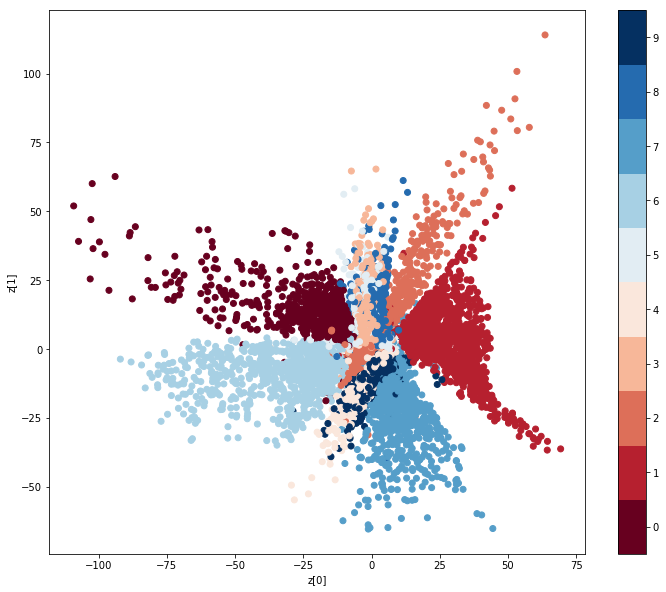

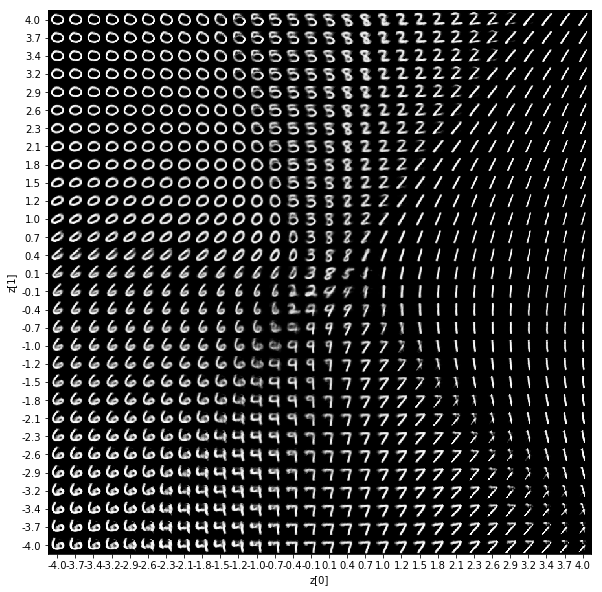

In [ ]:
models = (encoder, decoder)
data = (x_test, y_test)

# Generate distribution on latent space and manifold of the autoencoder
plot_results(models, data, batch_size=batch_size, model_name="aae_results")

In [ ]:
decoded_imgs = aae.predict(x_test)[0]

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()